##### 샘플 데이터

In [1]:
import pandas as pd
import pickle
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
with open("헬스 클러스터링 결과.pkl", "rb") as file :
    df = pickle.load(file)
df.head()

,time,Review,tagged_review,vector,cluster
0,2023. 5. 3. 11:52,좋은시와 글 홈트를 해요 영원한 물론입니다 여러분과 함께 홈트를 즐길 수 있는 영상...,"[좋다, 은시, 글, 홈트, 해, 영원하다, 홈트, 즐기다, 수, 영상, 준비, 영...","[0.8202861, 1.2661822, 0.11358889, 1.4388651, ...",0
1,2023. 5. 3. 10:02,뭘써볼까 는 집에서 틈틈이 운동하기 위해 홈트용 운동기구를 애요해요 꾸준히 하는 나...,"[뭘, 써다, 보다, 늘다, 집, 틈틈이, 운동, 위해, 홈트용, 운동, 기구, 애...","[0.51687, -0.23826225, -0.48169875, 0.9579804,...",4
2,2023. 5. 3. 9:01,주절주절 홈트를 해요 대 필수 매일 조금씩 세 줌마입니다 대 필수라고 생각하는 근...,"[홈트, 해, 대다, 필수, 매일, 세, 줌마, 대다, 필수, 생각, 근력, 운동,...","[0.6595078, 0.017418364, 1.2061758, 0.65224504...",1
3,2023. 2. 23. 19:00,건강 관리는 꾸준한 운동이 정답인것 같아요 건강 관리는 꾸준한 운동이 정답인것 같...,"[건강, 관리, 꾸준하다, 운동, 정답, 건강, 관리, 꾸준하다, 운동, 정답, 먹...","[-0.286165, -0.0006382484, -0.51053077, -0.286...",4
4,2021. 11. 10. 10:00,안녕 운동 운동 운동은매일매일출퇴근을 자전거로 해요분정도전력질주는 아니구요그리고 ...,"[안녕, 운동, 운동, 운동, 매일, 출퇴근, 자전거, 해, 분, 정도전, 질주, ...","[0.25458983, 0.1775183, -0.037466936, 0.238791...",4


# ◆ 1. LDA를 위한 데이터 전처리
* 1.1. 전체 단어의 사전 만들고 각 문서에 매칭하기
    > 단어들이 문서에 얼마나 위치해 있는지 분포를 파악해야하기 때문에 분석할 전체 데이터 대상으로
    사용된 단어의 사전을 생성해야한다,


In [3]:
# LDA 모델 그리기 위해 필요한 것들
import gensim
from gensim import corpora, models
from gensim.corpora import Dictionary

### 1.1 전체 단어의 사전 만들고 각 문서에 매칭하기

In [120]:
df_cluster1 = df[df['cluster'] == 5]
df_cluster1

,time,Review,tagged_review,vector,cluster
22,2022. 5. 12. 14:23,인생여행 가끔은 가볍고 칼로리 낮춘 음식을 먹어요 먹는 식단 자세히 알려드릴게요 ...,"[인생, 여행, 가끔, 가볍다, 칼로리, 낮추다, 음식, 먹다, 먹다, 식단, 자세...","[-0.84869367, 1.0518239, 0.13093169, 1.5244462...",5
49,2023. 4. 13. 23:18,질 서걱 답하기나름대로 건강하다고 자부를 했었는데 재작년쯤에 병원은 그렇지 않다는...,"[질, 답, 나름, 건강하다, 자부, 재작년, 병원, 그렇다, 않다, 판단, 내리다...","[-0.19914071, 1.1174172, -0.50500065, -0.34995...",5
80,2022. 5. 12. 14:55,동네 김밥집 김밥생각에서파는 메뉴인 김밥 김밥생각 경기도 수원시 영통구 도청로번길...,"[동네, 김밥, 집, 김밥, 생각, 팔다, 메뉴인, 김밥, 김밥, 생각, 경기도, ...","[-0.007822877, 0.5074913, 0.35591632, 1.189215...",5
88,2023. 2. 23. 11:44,고래요씨와 코로나가 시작되면서 생활은 다 바뀌었다 움직임이 덜해지고 집에 있는 ...,"[고래, 씨, 코로나, 시작, 생활, 바뀌다, 움직임, 덜하다, 집, 많아지다, 배...","[0.40525854, -0.5023206, 0.72236156, 0.8007038...",5
119,2023. 4. 13. 11:22,다이얻 다이어트 레시피로 강추하는 오이샐러드 오이와 올리브를 좋아한다면 맘에 들거...,"[얻다, 다이어트, 레시피, 강, 추하다, 오이, 샐러드, 오이, 올리브, 좋아하다...","[0.44961146, 0.9076235, 0.58936244, 0.31946644...",5
145,2022. 9. 21. 13:38,밍 프로 다이어터라고 할 수 있을까나는 어렸을 때부터 다이어트를 해왔다어렸을 때의 ...,"[밍, 프로, 다이어터, 수, 어리다, 다이어트, 해오다, 어리다, 누가, 보다, ...","[-0.2174618, 0.48769704, 2.492669, 2.1376538, ...",5
158,2023. 2. 24. 17:56,회기 경희대 골라담는 하와이 포케올데이 밍송 유나림 무얼 먹었니 요 밍송 그거 어...,"[회기, 경희대, 고르다, 담다, 하와이, 포케, 데이, 밍송, 유나, 림, 먹다,...","[-0.78619564, 0.2708145, -0.7793551, 1.5391592...",5
218,2023. 4. 13. 13:32,든든 한끼 다이어트에는 샐러드가 빠질 수 없죠 다이어트는 무엇보다도 적게 먹고 운동...,"[들다, 끼, 다이어트, 샐러드, 빠지다, 수, 없다, 다이어트, 적다, 먹다, 운...","[-0.40249687, 1.1689727, 0.6183574, 1.8610158,...",5
227,2022. 5. 12. 16:23,밥상 아주 오랜만에 답장을 하네요 의 레터에 여러번 답장을 하고 싶었으나늘 동영상을...,"[밥상, 아주, 만, 답장, 레터, 번, 답장, 싶다, 늘, 동영상, 포함, 답장,...","[-0.73424107, 1.2031045, 1.5202948, 1.970393, ...",5
233,2023. 4. 13. 19:03,닭가슴살 훈제 봉지를 준비합니다 냉장고에 있는 각종 야채들을 채 썰어 주고 닭가슴...,"[닭, 가슴, 살, 훈제, 봉지, 준비, 냉장고, 야채, 채, 썰다, 주다, 닭, ...","[-0.5493138, 0.16891642, 0.05165039, -0.004905...",5


In [122]:
all_documents = list(df_cluster1['tagged_review'])

dictionary = Dictionary(all_documents)
dictionary

In [123]:
dictionary.token2id

{'가꾸다': 0,
 '가끔': 1,
 '가다': 2,
 '가루': 3,
 '가볍다': 4,
 '가슴': 5,
 '가장': 6,
 '가져오다': 7,
 '간단하다': 8,
 '갈릭': 9,
 '갖다': 10,
 '개': 11,
 '거': 12,
 '걱정': 13,
 '건강하다': 14,
 '걸': 15,
 '겠다': 16,
 '고구마': 17,
 '고기': 18,
 '고민': 19,
 '공기': 20,
 '과장': 21,
 '구이': 22,
 '군데': 23,
 '그렇다': 24,
 '근처': 25,
 '기억': 26,
 '기프티콘': 27,
 '꼭': 28,
 '꾸준하다': 29,
 '끼': 30,
 '나가다': 31,
 '나서다': 32,
 '나진': 33,
 '날': 34,
 '남다': 35,
 '낮추다': 36,
 '느끼다': 37,
 '느낌': 38,
 '는걸': 39,
 '다니다': 40,
 '다양하다': 41,
 '다이어트': 42,
 '단백질': 43,
 '달': 44,
 '달다': 45,
 '닭': 46,
 '답답하다': 47,
 '당': 48,
 '대신': 49,
 '더': 50,
 '도움': 51,
 '도전': 52,
 '되어다': 53,
 '두': 54,
 '두유': 55,
 '드리다': 56,
 '들다': 57,
 '따끈따끈하다': 58,
 '라떼': 59,
 '루': 60,
 '마시기': 61,
 '마시다': 62,
 '만나다': 63,
 '많다': 64,
 '맛': 65,
 '맛있다': 66,
 '맞다': 67,
 '매일': 68,
 '먹다': 69,
 '먹어주다': 70,
 '메뉴인': 71,
 '모닝': 72,
 '모든': 73,
 '몸': 74,
 '미세하다': 75,
 '바디': 76,
 '바쁘다': 77,
 '반': 78,
 '받다': 79,
 '발아현미': 80,
 '밥': 81,
 '방울토마토': 82,
 '백미': 83,
 '밸런스': 84,
 '버전': 85,
 '병': 86,
 '보다': 87,
 '보이다': 88,

In [124]:
corpus = []
for doc in all_documents :
    corpus.append(dictionary.doc2bow(doc))
corpus # (id값, 빈도수)
len(corpus) # doc 값과 동일

50

# ◆ 2. LDA모델 만들기
* 2.1 LDA 기본 모델 만들기
* 2.2 LDA 토픽개수 선정
* 2.3 선정한 토픽 개수로 Action 넘버 매칭

### 2.1 LDA 기본 모델 만들기

In [125]:
topic_num = 3 # 임의로 가정

lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus, num_topics = topic_num, id2word =dictionary ) # 코드 불러오는 모델


In [127]:
lda_model.print_topics(num_words = 10) # 3개의 토픽에 대하여 5개의 주제 단어 정렬, 정렬순서는 큰 숫자 부터

[(0,
  '0.023*"먹다" + 0.011*"다이어트" + 0.008*"샐러드" + 0.006*"운동" + 0.006*"좋다" + 0.006*"음식" + 0.006*"만들다" + 0.006*"보다" + 0.005*"않다" + 0.005*"넣다"'),
 (1,
  '0.022*"먹다" + 0.013*"다이어트" + 0.009*"운동" + 0.008*"요거트" + 0.007*"맛있다" + 0.007*"보다" + 0.006*"샐러드" + 0.006*"좋다" + 0.005*"만들다" + 0.005*"그릭"'),
 (2,
  '0.045*"먹다" + 0.015*"다이어트" + 0.008*"살" + 0.008*"보다" + 0.007*"닭" + 0.007*"샐러드" + 0.006*"않다" + 0.006*"밥" + 0.006*"수" + 0.006*"가슴"')]

In [128]:
# 하나 뽑고 싶을 때
lda_model.get_document_topics(corpus)[0] # 첫 번째 문서에 대한 값 -> 1번 토픽일 것이다 -> 데이터에 새로운 열로 붙이기

[(2, 0.99822754)]

In [129]:
for i in range(len(corpus)) : 
    print(lda_model.get_document_topics(corpus)[i])

[(2, 0.9982269)]
[(2, 0.99716324)]
[(2, 0.9902433)]
[(0, 0.9306608), (2, 0.06839798)]
[(2, 0.98434)]
[(1, 0.110319585), (2, 0.8887377)]
[(0, 0.5886696), (2, 0.41069746)]
[(0, 0.77549136), (2, 0.22213854)]
[(1, 0.5190584), (2, 0.47968218)]
[(2, 0.98773104)]
[(1, 0.983869)]
[(1, 0.9952912)]
[(0, 0.9961945)]
[(0, 0.713817), (1, 0.2828915)]
[(0, 0.9117558), (2, 0.08423282)]
[(0, 0.02991428), (2, 0.9687263)]
[(2, 0.98907125)]
[(1, 0.2322251), (2, 0.7638191)]
[(1, 0.8132583), (2, 0.18034203)]
[(0, 0.010930172), (1, 0.0109927235), (2, 0.9780771)]
[(2, 0.9955301)]
[(0, 0.9880724)]
[(2, 0.9946512)]
[(2, 0.9884073)]
[(0, 0.9046083), (2, 0.09316737)]
[(2, 0.9986987)]
[(2, 0.98561025)]
[(1, 0.8852616), (2, 0.11216948)]
[(0, 0.6447268), (2, 0.35141808)]
[(0, 0.102696665), (2, 0.89558095)]
[(0, 0.9888624)]
[(1, 0.9929142)]
[(2, 0.9969235)]
[(0, 0.93211967), (2, 0.06386746)]
[(0, 0.037672147), (1, 0.40634185), (2, 0.555986)]
[(2, 0.99747574)]
[(1, 0.99674946)]
[(2, 0.99321127)]
[(2, 0.99469846)]
[(2,

### 2.2 LDA 토픽개수 선정
* cohearence & perplexcity

In [130]:
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import numpy as np

In [131]:
perplex_score = lda_model.log_perplexity(corpus)
perplex_score

-7.403132185423642

In [132]:
coherence_model = CoherenceModel(model = lda_model, texts = all_documents, dictionary = dictionary, topn = 3)
coherence_model.get_coherence()

0.5413304558556191

> 2.2.1 Perplexity 그래프 만들기

In [133]:
perplexity_values = []
for i in range(2, 10) :
    lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus, num_topics = i, id2word = dictionary)
    perp_v = lda_model.log_perplexity(corpus)
    perplexity_values.append(perp_v)
perplexity_values

[-7.292197879912096,
 -7.4270316964646215,
 -7.537543925855841,
 -7.6373931848672765,
 -7.794420721293404,
 -7.928194801835867,
 -7.953795357671586,
 -8.225356654092119]

Text(0, 0.5, 'perplexity score')

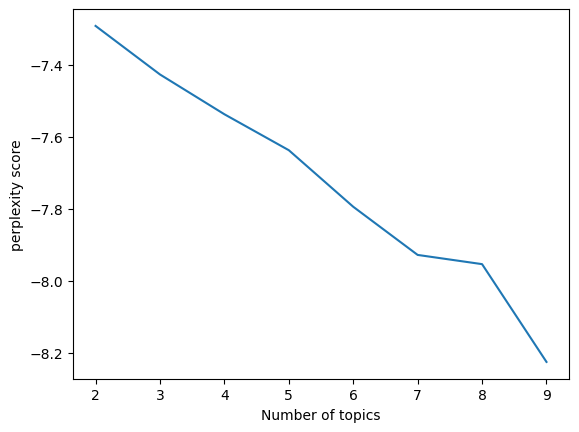

In [134]:
# 축 설정
x = range(2, 10)
plt.plot(x, perplexity_values)
plt.xlabel('Number of topics')
plt.ylabel('perplexity score')

> 2.2.1 Cohearence 그래프 만들기

In [135]:
coherence_values = []
for i in range(2, 10) :
    lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus, num_topics = i, id2word = dictionary)
    coherence_model = CoherenceModel(model = lda_model, texts = all_documents, dictionary = dictionary, topn = i)
    coherence_score = coherence_model.get_coherence()
    coherence_values.append(coherence_score)
coherence_values

[0.6536760114473297,
 0.536371570725319,
 0.47457686457584575,
 0.4313134405609157,
 0.40886839836905425,
 0.42418204195623277,
 0.3938019612835682,
 0.35259376766567113]

Text(0, 0.5, 'Coherence score')

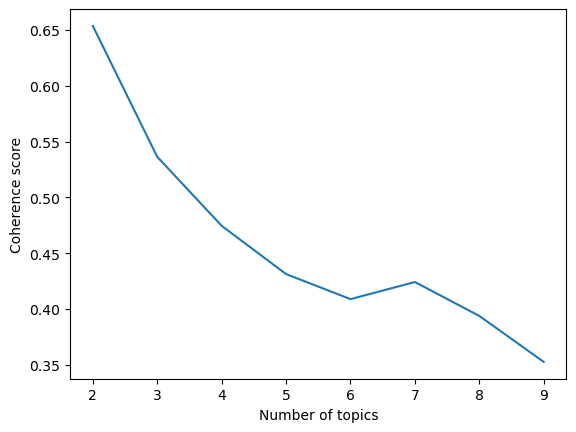

In [136]:
x = range(2, 10)
plt.plot(x, coherence_values)
plt.xlabel('Number of topics')
plt.ylabel('Coherence score')

### 2.3 선정한 토픽 개수로 Action 넘버 매칭

In [137]:
topic_n = 6
lda_model = gensim.models.LdaModel(corpus = corpus, num_topics = topic_n, id2word = dictionary, random_state = 1, passes = 5) 
# random_state : 돌릴 때마다 다른 값이 나오는데 항상 같은 값을 나오게 하는 방법
# passes : epoce 랑 비슷한 기능 -> 너무 크면 과적합 위험 있음

In [139]:
action_align = []
for doc in tqdm(lda_model.get_document_topics(corpus)) :
    label = [] # 클러스터 값
    value = [] # 확률값

    for score in doc :
        label.append(score[0]) # 클러스터값 넣기 위해서
        value.append(score[1]) # 확률값 넣기 위해서

    # 여러개의 (클러스터, 확률) 중 최대의 확률을 찾는 과정
    max_index = np.argmax(value)
    action_n = label[max_index]
    action_align.append(action_n)

action_align

100%|██████████| 50/50 [00:00<00:00, 4724.49it/s]


[3,
 3,
 4,
 1,
 0,
 3,
 5,
 2,
 4,
 3,
 2,
 4,
 5,
 2,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 2,
 0,
 0,
 2,
 4,
 0,
 3,
 4,
 0,
 0,
 0,
 3,
 2,
 2,
 3,
 3,
 3,
 5,
 3,
 0,
 4,
 3,
 1,
 4,
 1,
 0,
 4,
 0,
 2]

In [140]:
df_cluster1['action_cluster'] = action_align
df_cluster1

,time,Review,tagged_review,vector,cluster,action_cluster
22,2022. 5. 12. 14:23,인생여행 가끔은 가볍고 칼로리 낮춘 음식을 먹어요 먹는 식단 자세히 알려드릴게요 ...,"[인생, 여행, 가끔, 가볍다, 칼로리, 낮추다, 음식, 먹다, 먹다, 식단, 자세...","[-0.84869367, 1.0518239, 0.13093169, 1.5244462...",5,3
49,2023. 4. 13. 23:18,질 서걱 답하기나름대로 건강하다고 자부를 했었는데 재작년쯤에 병원은 그렇지 않다는...,"[질, 답, 나름, 건강하다, 자부, 재작년, 병원, 그렇다, 않다, 판단, 내리다...","[-0.19914071, 1.1174172, -0.50500065, -0.34995...",5,3
80,2022. 5. 12. 14:55,동네 김밥집 김밥생각에서파는 메뉴인 김밥 김밥생각 경기도 수원시 영통구 도청로번길...,"[동네, 김밥, 집, 김밥, 생각, 팔다, 메뉴인, 김밥, 김밥, 생각, 경기도, ...","[-0.007822877, 0.5074913, 0.35591632, 1.189215...",5,4
88,2023. 2. 23. 11:44,고래요씨와 코로나가 시작되면서 생활은 다 바뀌었다 움직임이 덜해지고 집에 있는 ...,"[고래, 씨, 코로나, 시작, 생활, 바뀌다, 움직임, 덜하다, 집, 많아지다, 배...","[0.40525854, -0.5023206, 0.72236156, 0.8007038...",5,1
119,2023. 4. 13. 11:22,다이얻 다이어트 레시피로 강추하는 오이샐러드 오이와 올리브를 좋아한다면 맘에 들거...,"[얻다, 다이어트, 레시피, 강, 추하다, 오이, 샐러드, 오이, 올리브, 좋아하다...","[0.44961146, 0.9076235, 0.58936244, 0.31946644...",5,0
145,2022. 9. 21. 13:38,밍 프로 다이어터라고 할 수 있을까나는 어렸을 때부터 다이어트를 해왔다어렸을 때의 ...,"[밍, 프로, 다이어터, 수, 어리다, 다이어트, 해오다, 어리다, 누가, 보다, ...","[-0.2174618, 0.48769704, 2.492669, 2.1376538, ...",5,3
158,2023. 2. 24. 17:56,회기 경희대 골라담는 하와이 포케올데이 밍송 유나림 무얼 먹었니 요 밍송 그거 어...,"[회기, 경희대, 고르다, 담다, 하와이, 포케, 데이, 밍송, 유나, 림, 먹다,...","[-0.78619564, 0.2708145, -0.7793551, 1.5391592...",5,5
218,2023. 4. 13. 13:32,든든 한끼 다이어트에는 샐러드가 빠질 수 없죠 다이어트는 무엇보다도 적게 먹고 운동...,"[들다, 끼, 다이어트, 샐러드, 빠지다, 수, 없다, 다이어트, 적다, 먹다, 운...","[-0.40249687, 1.1689727, 0.6183574, 1.8610158,...",5,2
227,2022. 5. 12. 16:23,밥상 아주 오랜만에 답장을 하네요 의 레터에 여러번 답장을 하고 싶었으나늘 동영상을...,"[밥상, 아주, 만, 답장, 레터, 번, 답장, 싶다, 늘, 동영상, 포함, 답장,...","[-0.73424107, 1.2031045, 1.5202948, 1.970393, ...",5,4
233,2023. 4. 13. 19:03,닭가슴살 훈제 봉지를 준비합니다 냉장고에 있는 각종 야채들을 채 썰어 주고 닭가슴...,"[닭, 가슴, 살, 훈제, 봉지, 준비, 냉장고, 야채, 채, 썰다, 주다, 닭, ...","[-0.5493138, 0.16891642, 0.05165039, -0.004905...",5,3


# ◆ 3. LDA 시각화 (LDAvis)


In [24]:
!pip install pyLDAvis

     ---------------------------------------- 0.0/59.0 kB ? eta -:--:--
     --------------------------- ------------ 41.0/59.0 kB ? eta -:--:--
     ---------------------------------------- 59.0/59.0 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
INFO: pip is looking at multiple versions of pyfume to determine which version is compatible with other requirements. This could take a while.
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   - -------------------------------------- 0.1/2.6 MB 4.5 MB/s eta 0:00:01
   ---- ----------------------------------- 0.3/2.6 MB 4.4 MB/s eta 0:00:01
   ----------------- ---------------------- 1.1/2.6 MB 7.8 MB/s eta 0:00:01
   -------------------------------- ------- 2.1/2.6 MB 11.3 MB/s eta 0:00:01
   ---------------------------------------- 2.6/2.6 MB

In [29]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis

In [141]:
prepared_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.save_html(prepared_data, 'ldavis_actor5.html')
pyLDAvis.display(prepared_data)

In [71]:
# 0번 클러스터가 안나와 -> 5개가 무작위로 섞여서 나온거라 수작업으로 조정해줘야해
topics = lda_model.show_topics(num_topics = -1, formatted = True)
topics

[(0,
  '0.020*"운동" + 0.011*"필라테스" + 0.009*"칼리" + 0.009*"스타" + 0.008*"연희동" + 0.007*"헬스장" + 0.007*"연희" + 0.005*"점" + 0.005*"양산시" + 0.004*"캠핑장"'),
 (1,
  '0.042*"운동" + 0.010*"보다" + 0.008*"좋다" + 0.008*"홈트" + 0.007*"자세" + 0.007*"않다" + 0.007*"수" + 0.007*"영상" + 0.007*"없다" + 0.006*"들다"'),
 (2,
  '0.014*"운동" + 0.010*"요가" + 0.007*"노래" + 0.007*"영상" + 0.007*"따르다" + 0.006*"정도" + 0.006*"다이어트" + 0.005*"끄다" + 0.005*"가다" + 0.005*"아니다"'),
 (3,
  '0.049*"운동" + 0.010*"점" + 0.010*"크로스핏" + 0.008*"필라테스" + 0.007*"영상" + 0.006*"보다" + 0.006*"들다" + 0.005*"내" + 0.005*"좋다" + 0.005*"않다"'),
 (4,
  '0.040*"운동" + 0.020*"보다" + 0.013*"따르다" + 0.012*"전신" + 0.011*"모멘트" + 0.011*"핏" + 0.011*"루틴" + 0.011*"랙" + 0.011*"션" + 0.011*"에디"'),
 (5,
  '0.017*"운동" + 0.011*"테니스" + 0.009*"크다" + 0.008*"보다" + 0.007*"진짜" + 0.007*"영상" + 0.006*"수" + 0.006*"분" + 0.006*"않다" + 0.005*"내"')]

In [72]:
new_action_topic = []
for i in df_cluster2.action_cluster :
    if i == 1 : # 처음에 설정한 액션 토픽 값
        new_n = 1 # vis에서 나온 토픽 넘버
    elif i == 2 : 
        new_n = 2
    elif i == 3 :
        new_n = 3
    elif i == 4 :
        new_n = 0
    else :
        new_n = 4

    new_action_topic.append(new_n)

In [32]:
df_cluster2.action_cluster = new_action_topic
df_cluster2

NameError: name 'new_action_topic' is not defined

In [142]:
#prepared_data.topic_order 활용해보기
new_index = [ i-1  for i in prepared_data.topic_order]
dict_topic_order = dict(zip(new_index, range(1, topic_n+1)))
 
df_cluster1["action_cluster"]=df_cluster1["action_cluster"].map(dict_topic_order)
df_cluster1

,time,Review,tagged_review,vector,cluster,action_cluster
22,2022. 5. 12. 14:23,인생여행 가끔은 가볍고 칼로리 낮춘 음식을 먹어요 먹는 식단 자세히 알려드릴게요 ...,"[인생, 여행, 가끔, 가볍다, 칼로리, 낮추다, 음식, 먹다, 먹다, 식단, 자세...","[-0.84869367, 1.0518239, 0.13093169, 1.5244462...",5,1
49,2023. 4. 13. 23:18,질 서걱 답하기나름대로 건강하다고 자부를 했었는데 재작년쯤에 병원은 그렇지 않다는...,"[질, 답, 나름, 건강하다, 자부, 재작년, 병원, 그렇다, 않다, 판단, 내리다...","[-0.19914071, 1.1174172, -0.50500065, -0.34995...",5,1
80,2022. 5. 12. 14:55,동네 김밥집 김밥생각에서파는 메뉴인 김밥 김밥생각 경기도 수원시 영통구 도청로번길...,"[동네, 김밥, 집, 김밥, 생각, 팔다, 메뉴인, 김밥, 김밥, 생각, 경기도, ...","[-0.007822877, 0.5074913, 0.35591632, 1.189215...",5,4
88,2023. 2. 23. 11:44,고래요씨와 코로나가 시작되면서 생활은 다 바뀌었다 움직임이 덜해지고 집에 있는 ...,"[고래, 씨, 코로나, 시작, 생활, 바뀌다, 움직임, 덜하다, 집, 많아지다, 배...","[0.40525854, -0.5023206, 0.72236156, 0.8007038...",5,2
119,2023. 4. 13. 11:22,다이얻 다이어트 레시피로 강추하는 오이샐러드 오이와 올리브를 좋아한다면 맘에 들거...,"[얻다, 다이어트, 레시피, 강, 추하다, 오이, 샐러드, 오이, 올리브, 좋아하다...","[0.44961146, 0.9076235, 0.58936244, 0.31946644...",5,3
145,2022. 9. 21. 13:38,밍 프로 다이어터라고 할 수 있을까나는 어렸을 때부터 다이어트를 해왔다어렸을 때의 ...,"[밍, 프로, 다이어터, 수, 어리다, 다이어트, 해오다, 어리다, 누가, 보다, ...","[-0.2174618, 0.48769704, 2.492669, 2.1376538, ...",5,1
158,2023. 2. 24. 17:56,회기 경희대 골라담는 하와이 포케올데이 밍송 유나림 무얼 먹었니 요 밍송 그거 어...,"[회기, 경희대, 고르다, 담다, 하와이, 포케, 데이, 밍송, 유나, 림, 먹다,...","[-0.78619564, 0.2708145, -0.7793551, 1.5391592...",5,6
218,2023. 4. 13. 13:32,든든 한끼 다이어트에는 샐러드가 빠질 수 없죠 다이어트는 무엇보다도 적게 먹고 운동...,"[들다, 끼, 다이어트, 샐러드, 빠지다, 수, 없다, 다이어트, 적다, 먹다, 운...","[-0.40249687, 1.1689727, 0.6183574, 1.8610158,...",5,5
227,2022. 5. 12. 16:23,밥상 아주 오랜만에 답장을 하네요 의 레터에 여러번 답장을 하고 싶었으나늘 동영상을...,"[밥상, 아주, 만, 답장, 레터, 번, 답장, 싶다, 늘, 동영상, 포함, 답장,...","[-0.73424107, 1.2031045, 1.5202948, 1.970393, ...",5,4
233,2023. 4. 13. 19:03,닭가슴살 훈제 봉지를 준비합니다 냉장고에 있는 각종 야채들을 채 썰어 주고 닭가슴...,"[닭, 가슴, 살, 훈제, 봉지, 준비, 냉장고, 야채, 채, 썰다, 주다, 닭, ...","[-0.5493138, 0.16891642, 0.05165039, -0.004905...",5,1


In [143]:
with open('./data/헬스 한글 크롤러 파일/health_cluster5.pkl', 'wb') as file :
    pickle.dump(df_cluster1,file)

pyLDAvis의 토픽 번호와 매핑된 모델 토픽 번호 출력 자동화 코드

In [ ]:

import pandas as pd
import pickle
from tqdm import tqdm
import warnings
import gensim
from gensim import corpora, models
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import numpy as np
import pyLDAvis.gensim as gensimvis
import pyLDAvis
 
warnings.filterwarnings('ignore')
 
def load_data(filepath):
    with open(filepath, 'rb') as file:
        return pickle.load(file)
 
def prepare_documents(df, cluster_label):
    cluster_data = df[df['cluster'] == cluster_label]
    return cluster_data['tagged_review'].tolist()
 
def create_dictionary(documents):
    return Dictionary(documents)
 
def create_corpus(documents, dictionary):
    return [dictionary.doc2bow(text) for text in documents]
 
def calculate_scores(corpus, dictionary, documents, start=2, end=10):
    perplexity_values = []
    coherence_values = []
   
    for i in tqdm(range(start, end), desc="Calculating Perplexity and Coherence Scores"):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=i, random_state=42)
        perplexity_values.append(model.log_perplexity(corpus))
        coherence_model = CoherenceModel(model=model, texts=documents, dictionary=dictionary, topn=i)
        coherence_values.append(coherence_model.get_coherence())
       
    return perplexity_values, coherence_values
 
def plot_scores(perplexity_values, coherence_values, start=2, end=10):
    x = range(start, end)
    plt.figure(figsize=(12, 6))
 
    plt.subplot(1, 2, 1)
    plt.plot(x, perplexity_values, marker='o')
    plt.xlabel('Number of topics')
    plt.ylabel('Perplexity score')
    plt.title('Perplexity Scores')
 
    plt.subplot(1, 2, 2)
    plt.plot(x, coherence_values, marker='o')
    plt.xlabel('Number of topics')
    plt.ylabel('Coherence score')
    plt.title('Coherence Scores')
 
    plt.tight_layout()
    plt.show()
 
def extract_topic_keywords(vis_data, num_topics):
    return [
        vis_data.topic_info[vis_data.topic_info.Category == f'Topic{i+1}']
        .sort_values('Freq', ascending=False)
        .Term.values[:10]
        for i in range(num_topics)
    ]
 
def map_topics(vis_keywords, model_keywords, num_topics):
    topic_mapping = {}
   
    for vis_idx, vis_kw in enumerate(vis_keywords):
        for model_idx, model_kw in enumerate(model_keywords):
            if set(vis_kw) == set(model_kw):
                topic_mapping[vis_idx + 1] = model_idx
                break
               
    return topic_mapping
 
def assign_topics_to_documents(ldamodel, corpus):
    action_align = []
 
    for doc in tqdm(ldamodel.get_document_topics(corpus), desc="Assigning Topics to Documents"):
        labels, values = zip(*doc)
        action_align.append(labels[np.argmax(values)])
 
    return action_align
 
# 데이터 로드
df = load_data('클러스터링 결과.pkl')
 
# 클러스터 0의 데이터 준비
documents = prepare_documents(df, cluster_label=0)
 
# 사전 및 코퍼스 생성
dictionary = create_dictionary(documents)
corpus = create_corpus(documents, dictionary)
 
# 퍼플렉서티 및 코히런스 점수 계산
perplexity_values, coherence_values = calculate_scores(corpus, dictionary, documents)
 
# 퍼플렉서티 및 코히런스 점수 그래프
plot_scores(perplexity_values, coherence_values)
 
# 최적 토픽 수로 LDA 모델 학습
optimal_topic_num = 10
ldamodel = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=optimal_topic_num, random_state=42)
 
# pyLDAvis 시각화 준비
prepared_data = gensimvis.prepare(ldamodel, corpus, dictionary)
 
# pyLDAvis와 ldamodel의 토픽 키워드 추출 및 매핑
vis_topic_keywords = extract_topic_keywords(prepared_data, optimal_topic_num)
model_topic_keywords = [[word for word, prob in ldamodel.show_topic(i, topn=10)] for i in range(optimal_topic_num)]
topic_mapping = map_topics(vis_topic_keywords, model_topic_keywords, optimal_topic_num)
 
# 토픽 확인
topics = ldamodel.show_topics(num_topics=optimal_topic_num, formatted=True)
for idx, topic in topics:
    print(f"Model Topic {idx}: {topic}")
 
# pyLDAvis의 토픽 번호와 매핑된 모델 토픽 번호 출력
print("\nTopic Mapping (pyLDAvis -> Model):")
for vis_idx, model_idx in topic_mapping.items():
    print(f"pyLDAvis Topic {vis_idx} -> Model Topic {model_idx}")
 
# 문서별 최적 토픽 할당
action_align = assign_topics_to_documents(ldamodel, corpus)
 
# 각 문서의 할당된 토픽 출력
print(action_align)
 
# pyLDAvis 시각화 파일 저장
pyLDAvis.save_html(prepared_data, 'pyLDAvis_output.html')
 
# pyLDAvis 시각화
pyLDAvis.display(prepared_data)
 

# ◆ 4. LDA 분석을 위한 후작업
* LDAvis와 LDA모델의 토픽 넘버 매칭
* LDAvis 결과와 LDA모델의 결과를 보고 직접 매칭해야한다.